In [3]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
import re
from pathlib import Path
from tempfile import TemporaryDirectory
from time import sleep

import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
from MDAnalysis.analysis import msd, rms
from mycolorpy import colorlist as mcp
from scipy.stats import linregress

from base import RD_MOLECULES, Mols

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams['figure.subplot.left'] = 0.12
plt.rcParams['figure.subplot.right'] = 0.99
plt.rcParams['figure.subplot.top'] = 0.99
plt.rcParams['figure.subplot.bottom'] = 0.1

# Traj analyse

In [4]:
def get_solve_dir(work_dir: str):
    paths = []
    result_dir = Path(work_dir)
    for system_sir in os.listdir(result_dir):
        # for T_dir in os.listdir(result_dir / system_sir):
            # paths.append(result_dir / system_sir / T_dir)
        paths.append(result_dir / system_sir)
    return sorted(paths)


def regress(data: pd.DataFrame):
    time, MSD = data.iloc[:, 0], data.iloc[:, 1]
    regression = linregress(time, MSD)
    S0 = regression.intercept
    S = regression.slope
    return S, S0


def strict(df: pd.DataFrame):
    slopes = []
    for i in np.arange(0, 200, 20):
        slopes.append((df.iloc[i, 0], regress(df.loc[i : i + 20])[0], i))
    slopes = np.array(slopes)
    need_slopes = slopes[(slopes[:, 1] - slopes[:, 1].mean()) / (slopes[:, 1].mean() + 1e-9) < 0.2]
    i0, i1 = need_slopes[0][2], need_slopes[-1][2]
    return df.loc[i0:i1], (i0, i1)

In [7]:
class D_results:
    D: float = None
    variation: float = 0
    MSD: pd.DataFrame = None
    unit: str = 'nm2/s'
    S: float = 0
    S0: float = 0
    start: float = 0
    end: float = 0

    def __init__(self, compound: Mols):
        self.compound = compound

    def __repr__(self):
        return f'<D_results: {self.D: .3e} (+/- {self.variation: .1e}) {self.unit}>'

    def MSD_mda(self, pdb: Path, traj: Path):
        u = mda.Universe(pdb, traj)
        selection = f'resname {self.compound.value}'

        m = msd.EinsteinMSD(u, select=selection)
        m.run()

        time = m.times
        MSD = np.mean(m.results['msds_by_particle'], axis=1)
        df, (i0, i1) = strict(pd.DataFrame({'Time': time, self.compound.name: MSD}))  # ps,  # nm
        S, S0 = regress(df)
        D = S / 6 * 1e12 / 1e14  # cm2/s
        self.D = D
        self.variation = 0
        self.MSD = df
        self.S = S
        self.S0 = S0
        self.start = i0
        self.end = i1

    def get_MSD_gmx(self, system: Path, traj: Path):
        with TemporaryDirectory() as temp_dir:
            temp_dir = Path(temp_dir)
            index_path = temp_dir / f'{self.compound.value}.ndx'
            xvg_path = temp_dir / f'{self.compound.value}.xvg'
            mol_path = temp_dir / f'{self.compound.value}_mol.xvg'

            command = f"""
                gmx -quiet select \
                -s {system} \
                -select {self.compound.value} \
                -on {index_path}

                gmx -quiet msd \
                -s {system} \
                -f {traj} \
                -n {index_path} \
                -o {xvg_path} \
                -beginfit 1500 \
                -endfit 3500 \
                """
            os.system(command)
            sleep(1)
            self._parse_xvg(xvg_path)
        self.S, self.S0 = regress(self.MSD[self.start : self.end])

    @staticmethod
    def _RMSD_mda(u, compound: Mols):
        residue = compound.value
        selection = f'resname {residue}'
        m = rms.RMSD(u, u, selection)
        m.run()
        return pd.DataFrame(m.results.rmsd[:, 1:], columns=['Time', residue])

    def _parse_xvg(self, xvg_path):
        with open(xvg_path) as file:
            data = file.readlines()
        D_pattern = r'D\[\s*(?P<name>\w+)\s*\] = (?P<value>[\d\.]+)\s*\(\+\/\- (?P<var>.+)\s*\)\s*\(\s*(?P<unit>.+)\s*\)'
        time_pattern = r'fitted from time\s(?P<start>\d+)\s*to\s*(?P<end>\d+).*'
        MSD_pattern = r'\s*(?P<time>\d+)\s*(?P<MSD>[\d\.]+).*'

        MSD = []
        D_flag = False
        for line in data:
            D_line = re.search(string=line, pattern=D_pattern)
            MSD_line = re.search(string=line, pattern=MSD_pattern)
            fit = re.search(string=line, pattern=time_pattern)

            if D_line:
                value = D_line.group('unit')
                scale, self.unit = [part.strip() for part in value.split(' ')]
                scale = float(scale)
                self.D = float(D_line.group('value')) * scale
                self.variation = float(D_line.group('var'))
                D_flag = True

            elif MSD_line and D_flag:
                time, msd = MSD_line.groups()
                MSD.append((int(time), float(msd)))

            elif fit:
                self.start = int(float(fit.group('start')) / 10)
                self.end = int(float(fit.group('end')) / 10)

        self.MSD = pd.DataFrame(np.array(MSD)[100:self.end], columns=['Time', self.compound.value])

## Test


In [28]:
# pdb = Path(r'gromacs/workspace/solvs/butanol_100_700/30/box.gro')
system = Path('gromacs/workspace/solvs/ocm_38_1539/30/5MD/system.tpr')
traj = Path(r'gromacs/workspace/solvs/ocm_38_1539/30/5MD/md.xtc')

In [29]:
but=D_results(Mols.butanol)
but.get_MSD_gmx(system=system, traj=traj)

Reading file gromacs/workspace/solvs/ocm_38_1539/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/ocm_38_1539/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file gromacs/workspace/solvs/ocm_38_1539/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file gromacs/workspace/solvs/ocm_38_1539/30/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  1140 elements
There is one group in the index

Now select a group for center of mass removal:
Group     0 (            BUT) has  1140 elements
There is one group in the index
Last frame        200 time  400.000   

Used 41 restart points spaced 10 ps over 400 ps



Fitting from 1500 to 4000 ps

Not enough points for fitting (0).
Can not determine the diffusion constant.


ValueError: Shape of passed values is (0, 1), indices imply (0, 2)

In [ ]:
ocm=D_results(Mols.ocm)
ocm.get_MSD_gmx(system=system, traj=traj)

In [ ]:
fig, ax = plt.subplots()
ax.set_ylabel('MSD [nm2]')
ax.set_xlabel('Time [ps]')

ax.scatter(
    a.MSD.iloc[:, 0],
    a.MSD.iloc[:, 1],
    label=f'{compound.name:7} [{a.D: 9.2e} cm2/s]',
    c='g',
    s=2,
)
ax.plot(a.MSD.iloc[:, 0], (a.S * a.MSD.iloc[:, 0] + a.S0), 'g')

# time_but = df_but['Time']

# ax.scatter(
#     time_but ,
#     df_but.iloc[:, 1] ,
#     label=f'butanol [{D_but: 9.2f} cm2/day]',
#     c='b',
#     s=2,
# )
# ax.plot(time_but , (S_but * time_but + S0_but) , 'b-')
ax.legend()

# ax.set_title(f"{compound} - {x} butanol :{T} C")
# fig.savefig(f"MSD_old.jpg", dpi=600)

In [ ]:
# for directory in get_solve_dir(Path('gromacs/workspace/solvs')):
#     name = r'.traj.xtc_offsets.lock'
#     name2 = r'.traj.xtc_offsets.npz'
#     os.remove(directory / name)
#     os.remove(directory / name2)

In [ ]:
solves_path=Path('gromacs/workspace/solvs')
plots_path=Path('gromacs/workspace/plots')
for directory in get_solve_dir(solves_path):
    compound, x, rho = directory.parent.stem.split('_')
    T = directory.stem
    compound = Mols[compound]

    system = directory / '5MD/system.tpr'
    traj = directory / '5MD/md.xtc'

    comp = D_results(compound)
    comp.get_MSD_gmx(system=system, traj=traj)
    but = D_results(Mols.butanol)
    if x != '0':
        but.get_MSD_gmx(system=system, traj=traj)

## loop

In [5]:
solves_path=Path('solvs_long')
plots_path=Path('plots_long')

Reading file solvs_long/butanol_100_700/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/butanol_100_700/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file solvs_long/butanol_100_700/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/butanol_100_700/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        500 time 5000.000   

Used 501 restart points spaced 10 ps over 5000 ps



Fitting from 1500 to 3500 ps

D[       BUT] 0.2341 (+/- 0.0100) 1e-5 cm^2/s


Reading file solvs_long/butanol_100_700_vap/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/butanol_100_700_vap/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file solvs_long/butanol_100_700_vap/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/butanol_100_700_vap/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            BUT) has  3000 elements
There is one group in the index
Last frame        500 time 5000.000   

Used 501 restart points spaced 10 ps over 5000 ps



Fitting from 1500 to 3500 ps

D[       BUT] 0.2598 (+/- 0.0071) 1e-5 cm^2/s


Reading file solvs_long/dmag_0_1069/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/dmag_0_1069/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file solvs_long/dmag_0_1069/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/dmag_0_1069/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            DMA) has  5600 elements
There is one group in the index
Last frame        500 time 5000.000   

Used 501 restart points spaced 10 ps over 5000 ps



Fitting from 1500 to 3500 ps

D[       DMA] 0.00901 (+/- 0.001247) 1e-5 cm^2/s


Reading file solvs_long/ocm_0_1520/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/ocm_0_1520/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file solvs_long/ocm_0_1520/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/ocm_0_1520/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            OCM) has 11000 elements
There is one group in the index
Last frame        500 time 5000.000   

Used 501 restart points spaced 10 ps over 5000 ps



Fitting from 1500 to 3500 ps

D[       OCM] 0.001608 (+/- 0.0002612) 1e-5 cm^2/s


Reading file solvs_long/peta_0_1200/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/peta_0_1200/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Analyzed topology coordinates
Reading file solvs_long/peta_0_1200/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)
Reading file solvs_long/peta_0_1200/5MD/system.tpr, VERSION 2021.4-Ubuntu-2021.4-2 (single precision)

Select a group to calculate mean squared displacement for:
Group     0 (            PET) has  7800 elements
There is one group in the index
Last frame        500 time 5000.000   

Used 501 restart points spaced 10 ps over 5000 ps



Fitting from 1500 to 3500 ps

D[       PET] 0.001506 (+/- 0.0002785) 1e-5 cm^2/s


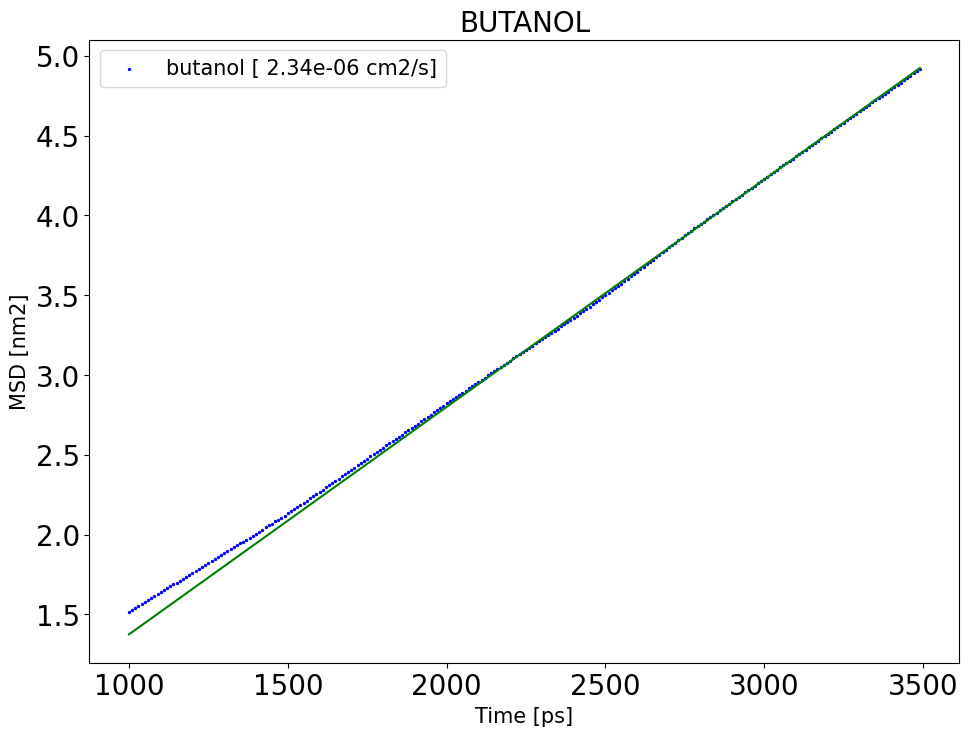

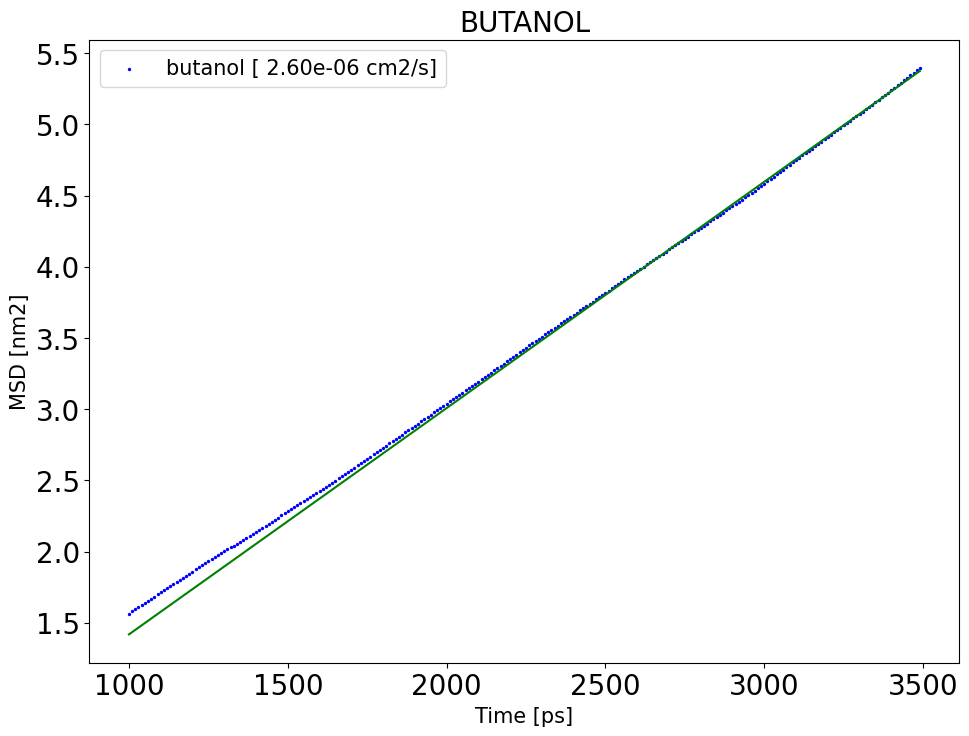

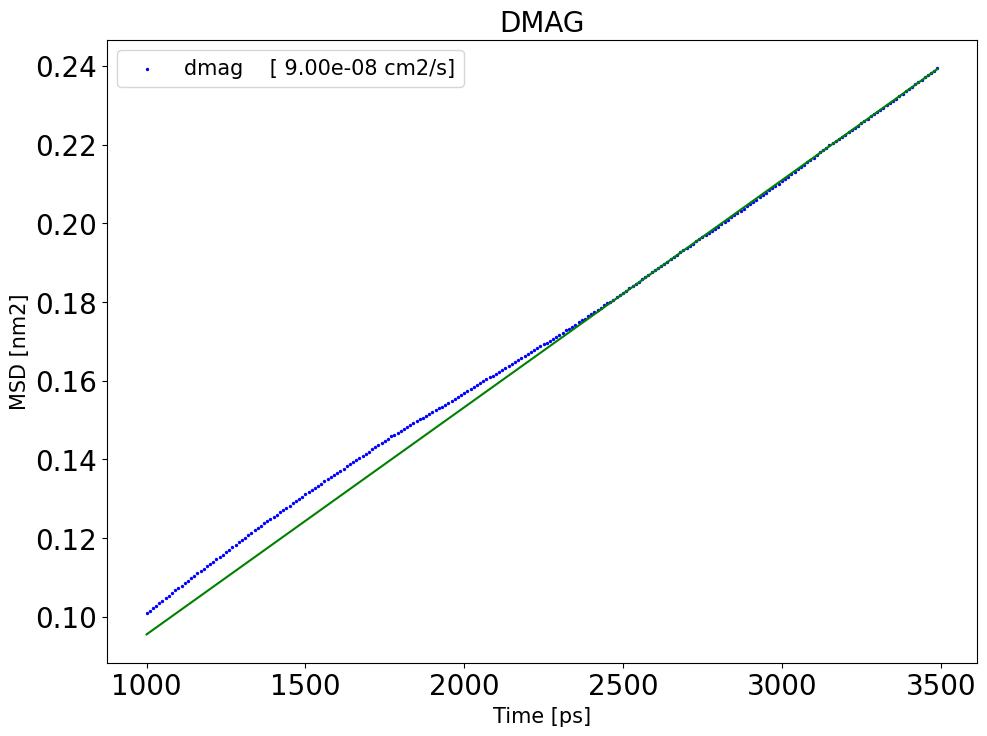

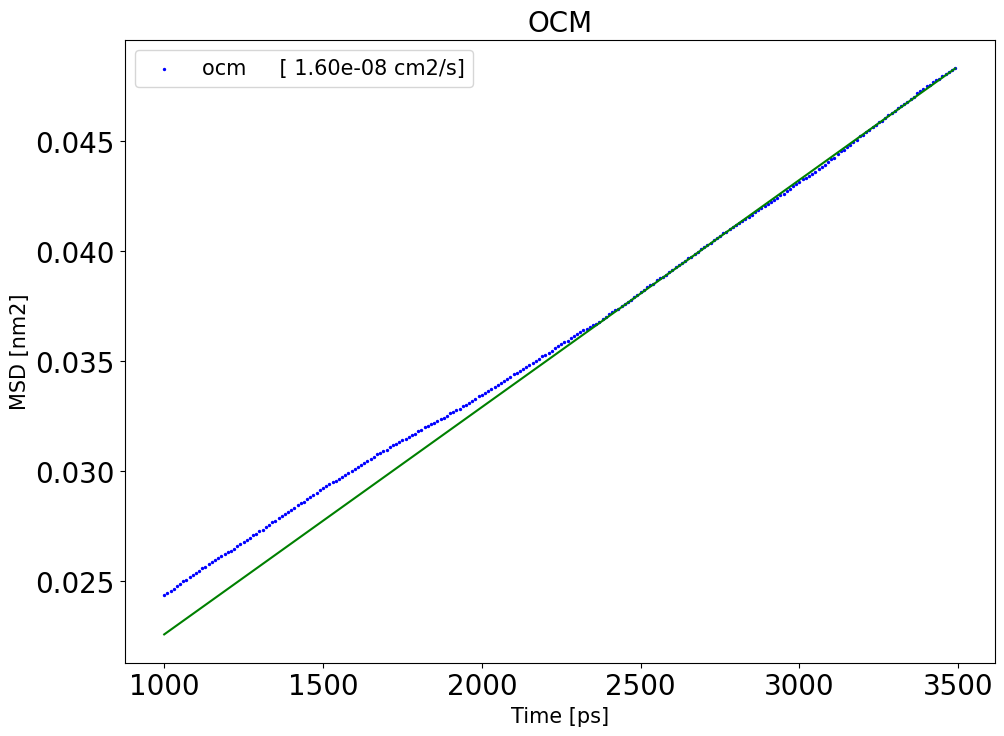

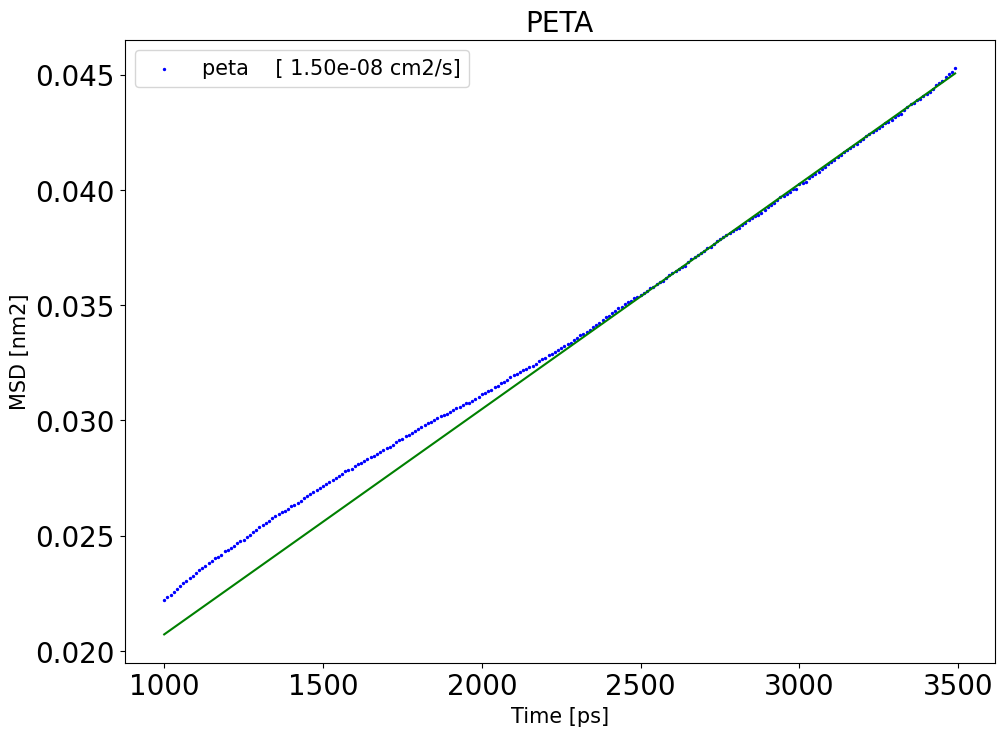

In [8]:
datas = []
for directory in get_solve_dir(solves_path):
    compound, x, rho, *_ = directory.stem.split('_')
    T = directory.stem
    compound = Mols[compound]

    system = directory / '5MD/system.tpr'
    traj = directory / '5MD/md.xtc'

    comp = D_results(compound)
    comp.get_MSD_gmx(system=system, traj=traj)

    #
    fig, ax = plt.subplots()
    ax.set_title(f"{compound.name.upper()}")
    ax.set_ylabel('MSD [nm2]')
    ax.set_xlabel('Time [ps]')

    ax.scatter(
        comp.MSD.iloc[:, 0],
        comp.MSD.iloc[:, 1],
        label=f'{compound.name:7} [{comp.D: 9.2e} cm2/s]',
        c='blue',
        s=2,
    )
    ax.plot(comp.MSD.iloc[:, 0], (comp.S * comp.MSD.iloc[:, 0] + comp.S0), 'g')

    ax.legend()
    plots_path.mkdir(parents=True, exist_ok=True)
    fig.savefig(plots_path / f"{directory.stem}.jpg", dpi=600)

    datas.append(
        {
            'compound': compound.name,
            'x': int(x),
            'Temperature': 25,
            'D': comp.D,
        }
    )
D_df = pd.DataFrame(datas)
# D_df.to_csv(Path(plots_path).parent / 'res.csv')

# D analyse

In [ ]:
D_df = pd.read_csv(r'gromacs/workspace/res.csv',index_col=0)

In [ ]:
D_df[D_df['compound']=='ocm']

In [ ]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(D_df['compound'].unique()),
)
i = 0
for compound in Mols:
    df_sub = D_df[D_df['compound'] == compound.name]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['Temperature'], ascending=False)
        ax.plot(
            data_x['Temperature'],
            data_x['D_comp'],
            label=f"{compound.name}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['Temperature'],
            data_x['D_but'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
        plt.show()
    i += 1